# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [48]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import utils_prep
from api import Benchmark
import utils_prep2
import torch

In [49]:
bench_dir = "/home/sven/LCBench/data/11604705/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [50]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [51]:
# Config
print("Config example:", test_data[0]["config"])
print("\n")
print("DATA Keys:", test_data[0].keys())

Config example: {'batch_size': 93, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.06145480624960298, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 402, 'mlp_shape': 'funnel', 'num_layers': True, 'learning_rate': 0.07306153347321286, 'momentum': 0.5844418984083981, 'weight_decay': 0.05967268273584057}


DATA Keys: dict_keys(['config', 'Train/loss', 'Train/train_accuracy', 'Train/val_accuracy', 'Train/train_cross_entropy', 'Train/val_cross_entropy', 'Train/train_balanced_accuracy', 'Train/val_balanced_accuracy', 'Train/test_result', 'Train/test_cross_entropy', 'Train/test_balanced_accuracy', 'Train/gradient_max', 'Train/gradient_mean', 'Train/gradient_median', 'Train/gradient_std', 'Train/gradient_q10', 'Train/gradient_q25', 'Train/gradient_q75', 'Train/gradient_q90',

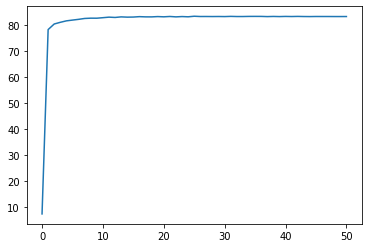

In [52]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

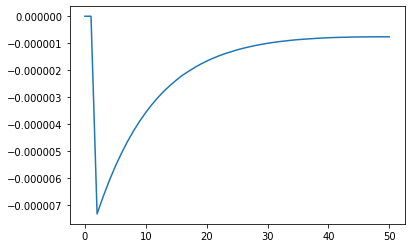

In [53]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

In [54]:
device = utils_prep2.check_cuda()


In [55]:
class LSTM_Net(torch.nn.Module):
    
    def __init__(self, input_size, num_classes, embedding_dim, hidden_size, seq_length, 
                 num_layers, config_size, bidirectional = False, drop_prob=0.5, relative_size = 0.2):
        super(LSTM_Net, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.config_size = config_size
        
        # self.forecaster = torch.nn.Embedding(100, embedding_dim)

        self.dropout = torch.nn.Dropout(drop_prob)
        self.lstm = torch.nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.num_layers, dropout =drop_prob, bidirectional = bidirectional)
        
 
        
        self.linear1 = torch.nn.Linear(self.config_size, int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear2 = torch.nn.Linear(int(self.hidden_dim*relative_size),
                                       int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear3 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size),
                                       self.hidden_dim + int(self.hidden_dim*relative_size))

        
        self.linear4 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size), self.hidden_dim//2)
        
        self.linear5 = torch.nn.Linear(self.hidden_dim//2, num_classes)

    
    def forward(self, x, configs, hidden):
        
        batch_size = x.size(0)

        x=x.unsqueeze(0)
        
        x = x.float()
        
        #forecast = self.forecaster(x)

        lstm_x, hidden = self.lstm(x, hidden)
        lstm_x = lstm_x.contiguous().view(-1, self.hidden_dim)
        x = self.dropout(lstm_x)

                                       
        x_config = torch.nn.functional.relu(self.linear1(configs))
        x_config = torch.nn.functional.relu(self.linear2(x_config))

        x_cat =  torch.cat([x, x_config], dim =1)

        
        x_cat = torch.nn.functional.relu(self.linear3(x_cat))
        x_cat = torch.nn.functional.relu(self.linear4(x_cat))
        x_cat = self.linear5(x_cat)

        
        x_cat = x_cat.view(batch_size, -1)
        x_cat = x_cat[:,-1]
        
        return x_cat, hidden
    
    def init_hidden(self, batch_size = 32):
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    

In [56]:
def create_model(input_size = 10):

    input_size = input_size
    outcome_dim = 1
    embedding_dim = 400
    hidden_dim = 50
    seq_length = 1
    num_layers = 3
    config_size = 7

    model = LSTM_Net(input_size, outcome_dim, embedding_dim, hidden_dim, seq_length, num_layers, config_size,
                     relative_size = 0.75)
    model.to(device)

    lr=0.001
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.001)
    
    return model, optimizer, criterion

In [57]:
def train_validate_model(model, optimizer, criterion):
    
    epochs = 2000
    counter = 0
    print_every = 200

    clip = 5
    valid_loss_min = np.Inf


    model.train()

    for i in range(epochs):


        for batches, configs , labels in train_data_loader:
            counter += 1

            batch_size_calc = len(labels)
            hidden = model.init_hidden(batch_size=batch_size_calc)


            model.zero_grad()

            output, hidden = model(batches, configs, hidden)


            loss = abs(criterion(output.squeeze(), labels.float()))
            loss.backward()


            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()


            if counter%print_every == 0:

                val_losses = []
                model.eval()

                for inp,configs, lab in val_data_loader:

                    batch_size_calc = len(lab)

                    val_h = model.init_hidden(batch_size = batch_size_calc)


                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, configs,val_h)
                    val_loss = abs(criterion(out.squeeze(), lab.float()))
                    val_losses.append(val_loss.item())

                    print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), '/home/sven/LCBench/state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)
                
                model.train()


    return


In [58]:
def test_model(model, criterion):
    
    model.load_state_dict(torch.load('/home/sven/LCBench/state_dict.pt'))

    test_losses = []
    msqrt = 0
    counter = 0


    model.eval()
    for inputs,configs, labels in test_data_loader:
        counter = counter +1
        batch_size_calc = len(labels)
        h = model.init_hidden(batch_size_calc)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs,configs, h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        pred = (output.squeeze())

        msqrt = msqrt + mean_squared_error(labels.detach().numpy(), pred.detach().numpy())
    
        print((labels.detach()))
        print((pred.detach()))
    print(counter)
    total_test_acc = msqrt
    print("TOTAL Loss: {:.3f}".format(total_test_acc))
    test_acc2 = msqrt/counter
    
    print("Msqrt: {:.3f}".format(test_acc2))

    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    
    return test_acc, np.mean(test_losses)


In [59]:
from utils import prep_data



train_data_loader = prep_data(train_data, train_targets, batch_size = 32,first_n_epochs = 10 )
test_data_loader = prep_data(test_data, test_targets, batch_size = 32,first_n_epochs = 10 )
val_data_loader = prep_data(val_data, val_targets, batch_size = 32, first_n_epochs=10)


model, optimizer, criterion = create_model(input_size = 10)
train_validate_model(model, optimizer, criterion)
    
    


Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 36.413151
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 34.874458
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 40.541397
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 37.414825
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 40.839330
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 46.287458
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 41.973221
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 39.351261
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 39.728506
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 38.493452
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 39.455660
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 41.114466
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 41.023530
Epoch: 7/2000... Step: 200... Loss: 102.066483... Val Loss: 41.266410
Epoch: 7/2000... Ste

Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 7.998251
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 10.699664
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 12.047720
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 12.091826
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 12.848121
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 17.472272
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 16.621503
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 15.743052
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 14.903518
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 14.323702
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 13.704627
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 14.148885
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 13.672058
Epoch: 57/2000... Step: 1800... Loss: 14.042742... Val Loss: 14.380869
Epoch: 

Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 9.019120
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 10.608484
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 11.409442
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 11.702715
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 12.347642
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 14.500039
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 13.847661
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 13.105995
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 12.594054
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 12.297116
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 11.861220
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 12.457303
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 12.069433
Epoch: 107/2000... Step: 3400... Loss: 11.784443... Val Loss: 12.

Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 13.679989
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.206313
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.007258
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.601400
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.656551
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 18.222574
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 17.724900
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 17.119441
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.616356
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.264163
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 15.850940
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 16.217655
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 15.882960
Epoch: 157/2000... Step: 5000... Loss: 14.655961... Val Loss: 17

Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 6.737236
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 5.641028
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 6.220694
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.096809
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.099712
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 8.508186
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 8.088697
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.760632
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.465474
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.169807
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 6.772610
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.101295
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 6.787712
Epoch: 207/2000... Step: 6600... Loss: 4.771071... Val Loss: 7.416989
Epoch: 207/2000... S

Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.065260
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 7.872734
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.260605
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 9.366263
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 9.182207
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 10.068866
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 9.737538
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 9.226895
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.904032
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.713850
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.355701
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.607700
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 8.299019
Epoch: 257/2000... Step: 8200... Loss: 7.362272... Val Loss: 9.182986
Epoch: 257/2000... 

Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.672942
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.313700
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.621595
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 8.526948
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 8.208915
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 8.529266
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 8.239487
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 8.083605
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.850798
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.608333
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.352901
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.552223
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 7.309186
Epoch: 307/2000... Step: 9800... Loss: 7.863524... Val Loss: 8.148170
Epoch: 307/2000... S

Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.210240
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 6.207309
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 6.723917
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.340023
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.348238
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 8.497944
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 8.010478
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.583223
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.326884
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.082133
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 6.849709
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.083983
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 6.814274
Epoch: 357/2000... Step: 11400... Loss: 7.834246... Val Loss: 7.557369
Epoch:

Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.509754
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.236155
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.565908
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.985934
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.826970
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 9.235878
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 8.589409
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 8.194443
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.960668
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.644518
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.361289
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.572826
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 7.348466
Epoch: 407/2000... Step: 13000... Loss: 8.469484... Val Loss: 8.289262
Epoch:

Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.687585
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 7.923843
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.089191
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.673348
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.572717
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 9.427940
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.897593
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.621037
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.374860
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.044864
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 7.784018
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.016617
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 7.819348
Epoch: 457/2000... Step: 14600... Loss: 6.081038... Val Loss: 8.550651
Epoch:

Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.822745
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 4.542908
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 4.953272
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.411101
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.283418
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.989133
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.480060
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.200876
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.020788
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 4.820095
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 4.639272
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 4.822067
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 4.640699
Epoch: 507/2000... Step: 16200... Loss: 3.064079... Val Loss: 5.373264
Epoch:

Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.359720
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 6.988101
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 6.883606
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.801647
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.594713
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 8.551545
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.964305
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.782087
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.529717
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.233967
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.062284
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.197962
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.110151
Epoch: 557/2000... Step: 17800... Loss: 7.035603... Val Loss: 7.868748
Epoch:

Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 5.291804
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.342574
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.437302
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.995416
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.911935
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 5.898828
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 5.404521
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 5.296633
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 5.096863
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.808902
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.683511
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.831724
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 4.716663
Epoch: 607/2000... Step: 19400... Loss: 4.100084... Val Loss: 5.427550
Epoch:

Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 6.550604
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.279285
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.217004
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.594659
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.283033
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 6.044566
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.774250
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.670285
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.461788
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.312874
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.179718
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.281536
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.155424
Epoch: 657/2000... Step: 21000... Loss: 4.465413... Val Loss: 5.829811
Epoch:

Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 4.821787
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.222967
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.452239
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.871682
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.825149
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 4.461049
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 4.241753
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 4.244695
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 4.105849
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.899342
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.776339
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.926905
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 3.794187
Epoch: 707/2000... Step: 22600... Loss: 4.340904... Val Loss: 4.484550
Epoch:

Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 7.702932
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 5.942956
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 5.879688
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.583072
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.477188
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 7.370298
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 7.160391
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 7.045560
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.871651
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.646489
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.579517
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.682335
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 6.568952
Epoch: 757/2000... Step: 24200... Loss: 5.320041... Val Loss: 7.134080
Epoch:

Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 5.049743
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.653914
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.564104
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.583624
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.432362
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 4.279948
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 4.094867
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 4.151811
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 4.024253
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.853980
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.829087
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.855512
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 3.712067
Epoch: 807/2000... Step: 25800... Loss: 3.063945... Val Loss: 4.470343
Epoch:

Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 4.061287
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 2.989347
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 2.982050
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.305250
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.288973
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.666264
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.397681
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.412575
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.326819
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.147740
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.070458
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.186604
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.120584
Epoch: 857/2000... Step: 27400... Loss: 1.878682... Val Loss: 3.968264
Epoch:

Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 5.090771
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.167114
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.076070
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.226715
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.089849
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.142769
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 2.941905
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.002980
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 2.935289
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 2.861669
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 2.800522
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 2.858249
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 2.803765
Epoch: 907/2000... Step: 29000... Loss: 2.031256... Val Loss: 3.473382
Epoch:

Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 5.694009
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.364589
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.134852
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.250238
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.086120
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.491442
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.215926
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.185836
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.132776
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.055914
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 3.988761
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.057343
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.051179
Epoch: 957/2000... Step: 30600... Loss: 4.799028... Val Loss: 4.830284
Epoch:

Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 6.051786
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.963417
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.601394
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.744745
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.771377
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.899761
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.778000
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.707257
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.663891
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.601661
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.517498
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.593895
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 3.527896
Epoch: 1007/2000... Step: 32200... Loss: 2.368666... Val Loss: 4

Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 4.747328
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.367197
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.258877
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.474715
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.677669
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 4.119630
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.824763
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.736877
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.634834
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.508784
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.401500
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.486153
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 3.448349
Epoch: 1057/2000... Step: 33800... Loss: 2.077533... Val Loss: 4

Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 4.857456
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 3.192833
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.811211
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.885897
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 3.009988
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 3.334154
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 3.117173
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 3.123997
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.978231
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.909167
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.862454
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.879013
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 2.803958
Epoch: 1107/2000... Step: 35400... Loss: 1.283634... Val Loss: 3

Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 5.036551
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.144021
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 2.784119
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 2.930527
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.000753
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.303354
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.200816
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.277993
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.205041
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.103936
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.075985
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.135127
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3.058540
Epoch: 1157/2000... Step: 37000... Loss: 1.688323... Val Loss: 3

Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 4.242970
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 2.882180
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 2.703514
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.123970
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.283917
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.885294
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.560372
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.440606
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.390382
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.260887
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.171989
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.258997
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3.216158
Epoch: 1207/2000... Step: 38600... Loss: 1.563044... Val Loss: 3

Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 4.034806
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 2.576093
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 2.601616
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3.120401
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3.137778
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3.333218
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3.099631
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3.054868
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3.042637
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 2.925247
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 2.844375
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 2.935499
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 2.920207
Epoch: 1257/2000... Step: 40200... Loss: 2.209723... Val Loss: 3

Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 5.822588
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.966311
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.490056
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 4.014554
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.977359
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.986269
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.760792
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.729728
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.702297
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.649031
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.535684
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.524100
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 3.576064
Epoch: 1307/2000... Step: 41800... Loss: 1.637690... Val Loss: 4

Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 4.109782
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.588642
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.315984
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.751172
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.713089
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.947053
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.806814
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.898031
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.823399
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.730128
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.757524
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.717003
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 2.642185
Epoch: 1357/2000... Step: 43400... Loss: 2.347775... Val Loss: 3

Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 6.910289
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.987378
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.279202
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.681904
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.528012
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.932688
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.674592
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.588956
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.594891
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.534749
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.470465
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.424600
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 4.508004
Epoch: 1407/2000... Step: 45000... Loss: 3.167730... Val Loss: 5

Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 5.087811
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.293461
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 2.836521
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.254225
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.152535
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.802205
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.593187
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.524240
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.464672
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.356733
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.328779
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.304785
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3.249871
Epoch: 1457/2000... Step: 46600... Loss: 2.997713... Val Loss: 3

Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 5.496129
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 3.799947
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 3.345652
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.129559
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.108517
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.752933
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.419149
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.274215
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.209423
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.109288
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4.009556
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 3.964620
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 3.969058
Epoch: 1507/2000... Step: 48200... Loss: 1.602241... Val Loss: 4

Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 7.658030
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.861648
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.264729
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.730213
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.601543
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 6.005233
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.813368
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.652932
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.639508
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.630614
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.579928
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.529292
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 5.609388
Epoch: 1557/2000... Step: 49800... Loss: 3.040096... Val Loss: 6

Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 5.780314
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.075555
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 3.545990
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.265632
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.116984
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.588852
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.247702
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.113955
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.088033
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4.045777
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 3.987867
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 3.949628
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 3.969879
Epoch: 1607/2000... Step: 51400... Loss: 2.503285... Val Loss: 4

Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 4.210163
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.612241
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.342711
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.820959
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.829291
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 3.198919
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 3.024319
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 3.002359
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.933171
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.847987
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.884835
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.817607
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 2.719982
Epoch: 1657/2000... Step: 53000... Loss: 1.163773... Val Loss: 3

Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4.682803
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.422622
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.514662
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4.092138
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4.234271
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4.599572
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4.266232
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4.019844
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.936659
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.915592
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.891277
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.918559
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 3.884091
Epoch: 1707/2000... Step: 54600... Loss: 3.130327... Val Loss: 4

Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 4.050462
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.575968
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.433266
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.963611
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.990099
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 3.724909
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 3.327856
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 3.214644
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 3.131659
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 3.024102
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.977818
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.940644
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 2.870553
Epoch: 1757/2000... Step: 56200... Loss: 1.324206... Val Loss: 3

Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 6.636251
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.262954
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.015971
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.565628
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.622080
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 6.481589
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 6.238243
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.890269
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.815666
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.728620
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.538086
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.503417
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 5.431004
Epoch: 1807/2000... Step: 57800... Loss: 2.541652... Val Loss: 6

Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 4.142529
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.616430
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.215180
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.627540
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.561015
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 3.004407
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.855141
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.837031
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.765586
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.773598
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.957705
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.848633
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 2.750662
Epoch: 1857/2000... Step: 59400... Loss: 0.884074... Val Loss: 3

Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.730152
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 2.436547
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 2.580333
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.116854
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.162583
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.766206
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.492018
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.400780
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.338169
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.261185
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.381002
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.316688
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3.178299
Epoch: 1907/2000... Step: 61000... Loss: 1.041762... Val Loss: 3

Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 3.678904
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.287741
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.014901
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.573304
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.627633
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 3.322940
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.975675
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.951722
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.903049
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.794886
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.785517
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.702682
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 2.610937
Epoch: 1957/2000... Step: 62600... Loss: 0.886027... Val Loss: 3

In [60]:
test_acc, msqrt = test_model(model, criterion)


tensor([83.5056, 81.3736, 80.0233, 81.2056, 83.1180, 81.3025, 84.1388, 80.9148,
        84.1646, 70.7779, 59.4650, 70.4419, 81.4640, 80.5401, 82.1489, 83.8610,
        81.8969, 59.4327, 79.8294, 83.2860, 83.6607, 78.5890, 71.3012, 75.5847,
        51.6346, 73.3687, 78.2272, 81.9421, 81.5157, 82.1166, 76.8510, 81.7095])
tensor([83.4315, 81.3518, 78.6776, 80.6873, 82.8128, 81.6355, 85.0174, 81.0411,
        84.3208, 69.2617, 55.6905, 72.7859, 80.0380, 81.4923, 82.2792, 84.6914,
        80.9904, 64.5527, 80.2922, 83.1278, 84.3212, 77.3441, 69.3791, 73.6370,
        53.0603, 73.7312, 79.4034, 82.7655, 81.2402, 82.9738, 77.8426, 81.9449])
tensor([82.3298, 83.9643, 59.0322, 83.9191, 84.3455, 84.1840, 80.6177, 84.4812,
        80.9665, 82.7756, 84.0871, 82.8983, 83.1890, 78.0204, 88.0346, 84.0806,
        83.8351, 82.6916, 89.1717, 80.6952, 68.0062, 77.3679, 72.8195, 84.2938,
        83.0727, 84.6233, 74.5768, 83.2472, 84.1194, 82.5688, 82.0390, 83.3247])
tensor([82.3615, 84.0750, 62.4047, 84

## A simple baseline

In [61]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [62]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
for data in train_data:
    data['Train/val_accuracy']=data['Train/val_accuracy'][0:10]

predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [63]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523
